L'objectif de ce TP est d'analyser l'évolution du nombre de lymphocytes CD4 au cours du temps chez des patients infectés par le VIH, en s'intéressant aux effets du traitement IL-2 et aux éventuels effets d'autres covariables ou facteurs. On dispose des données de 70 patients. Les variables à l'inclusion sont :

- `numpat` : numéro du patient dans l'essai ;

- `groupe` : groupe de traitement (1=IL-2 ; 2=contrôle) ;

- `stratcd4` : groupe de CD4 à l'inclusion (1=CD4<100 ; 2=CD4>100) ;

- `age` : âge du patient au moment de l'inclusion ;

- `sexe` : sexe du patient (1=Homme ; 2=Femme) ;

- `trans` : groupe de transmission (1=homo-bisexuel ; 2=hétérosexuel ; 3=toxicomane ; 4=autre) ;

- `agesero` : âge auquel la séropositivité du patient a été détectée ;

- `dureevih` : durée depuis la détection de la séropositivité ;

- `vihact` : présence de manifestations liées au VIH à l'inclusion (0=non ; 1=oui) ;

- `poids` : poids du patient à l'inclusion.

Les variables de suivi au cours de l'essai sont :

- de `cd4S0` à `cd4S24`: nombre de lymphocytes CD4 à chaque visite de S0 à S24.

On commencera par une analyse descriptive. On observera ensuite l'évolution des `cd4` en fonction du temps et selon le groupe de traitement, puis on cherchera à voir si la prise en compte d'autres covariables ou facteurs permet d'améliorer le modèle.

In [1]:
library('car')
library('nlme')

In [2]:
options(warn=-1)
data <- read.csv('CD4.csv', sep=',')
cat(dim(data))

70 15

In [3]:
rownames(data) <- data$numpat  # id = index
attach(data)

expl_vars <- c('groupe', 'stratcd4', 'age', 'sexe', 'trans', 'agesero', 'dureevih', 'vihact', 'poids')
num_vars <- c('age', 'agesero', 'dureevih', 'poids')  # numériques
fact_vars <- setdiff(expl_vars, num_vars)  # facteurs
target <- c('cd4S0', 'cd4S6', 'cd4S12', 'cd4S18', 'cd4S24')

# Convertir en facteurs
for(var in fact_vars){
    data[, var] <- as.factor(data[, var])
}

# Analyse descriptive simple

## Résumé

Le jeu de données comporte des valeurs manquantes. Pour l'analyse descriptive et la modélisation de l'évolution des `cd4` en fonction du temps et selon le groupe de traitement, les valeurs manquantes dans les `cd4` peuvent fausser les résultats. En supprimant les observations des individus correspondants, qui appartiennent tous au groupe 1, il nous reste 66 observations sur les 70 initiales.
<br>Il n'est en revanche pas nécessaire de supprimer les observations comportant d'autres variables manquantes (`agesero` et `dureevih`). On les supprimera lorsqu'on voudra les utiliser, en seconde partie.

In [4]:
# Retirer les cd4 manquantes
data <- data[complete.cases(data[, 2:6]),]
cd4 <- data.frame(data[, 2:6])
cd4 <- cd4[complete.cases(cd4),]
attach(data)
cd4 <- as.matrix(cd4)

In [5]:
cat(paste(dim(data)[1], 'observations'))

66 observations

In [6]:
summary(data[,-c(1)])

     cd4S0           cd4S6           cd4S12          cd4S18     
 Min.   : 20.0   Min.   : 30.0   Min.   : 30.0   Min.   : 31.0  
 1st Qu.:110.8   1st Qu.:123.0   1st Qu.:135.5   1st Qu.:131.2  
 Median :143.5   Median :153.0   Median :176.5   Median :187.0  
 Mean   :138.3   Mean   :166.1   Mean   :175.0   Mean   :188.6  
 3rd Qu.:164.5   3rd Qu.:203.0   3rd Qu.:217.8   3rd Qu.:231.5  
 Max.   :216.0   Max.   :351.0   Max.   :360.0   Max.   :515.0  
                                                                
     cd4S24      groupe stratcd4      age        sexe   trans     agesero     
 Min.   : 30.0   1:30   1:11     Min.   :26.00   1:58   1:34   Min.   :15.00  
 1st Qu.:142.2   2:36   2:55     1st Qu.:37.50   2: 8   2:17   1st Qu.:32.75  
 Median :195.5                   Median :44.50          3:10   Median :39.00  
 Mean   :188.1                   Mean   :45.91          4: 5   Mean   :40.39  
 3rd Qu.:225.0                   3rd Qu.:52.00                 3rd Qu.:47.00  
 Max. 

On dispose désormais de 66 observations : 30 dans le groupe IL-2 et 36 dans le groupe contrôle. On a converti les variables catégorielles en facteurs (classe `factor`). 
<br>
On peut voir notamment que 87.87% des individus sont des hommes. Plus de la moitié des individus sont homosexuels ou bisexuels (51.51%). 16.67% des individus présentaient un faible nombre de CD4 à l'inclusion (CD4<100). 31.82% présentaient des manifestations liées au VIH à l'inclusion.

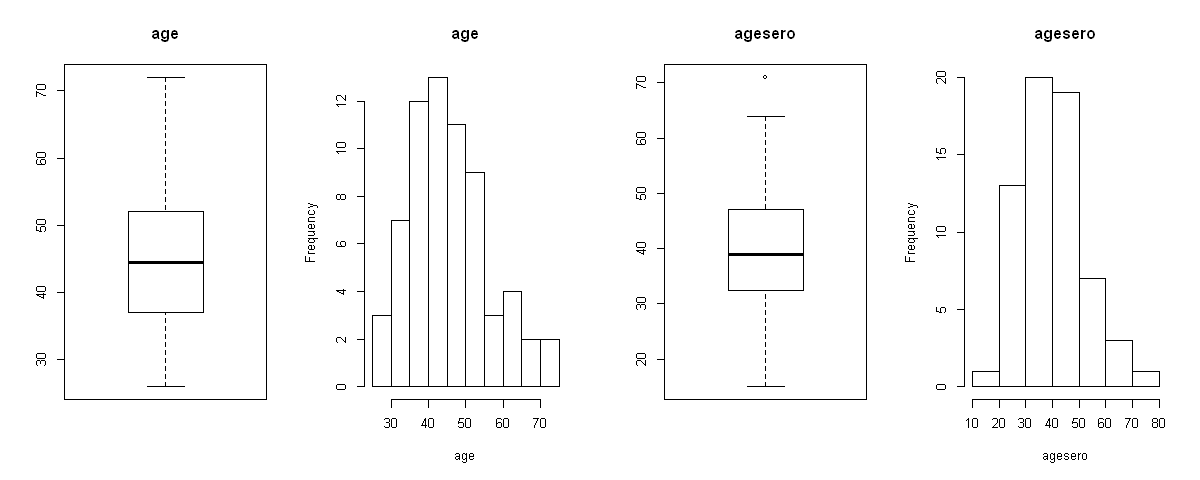

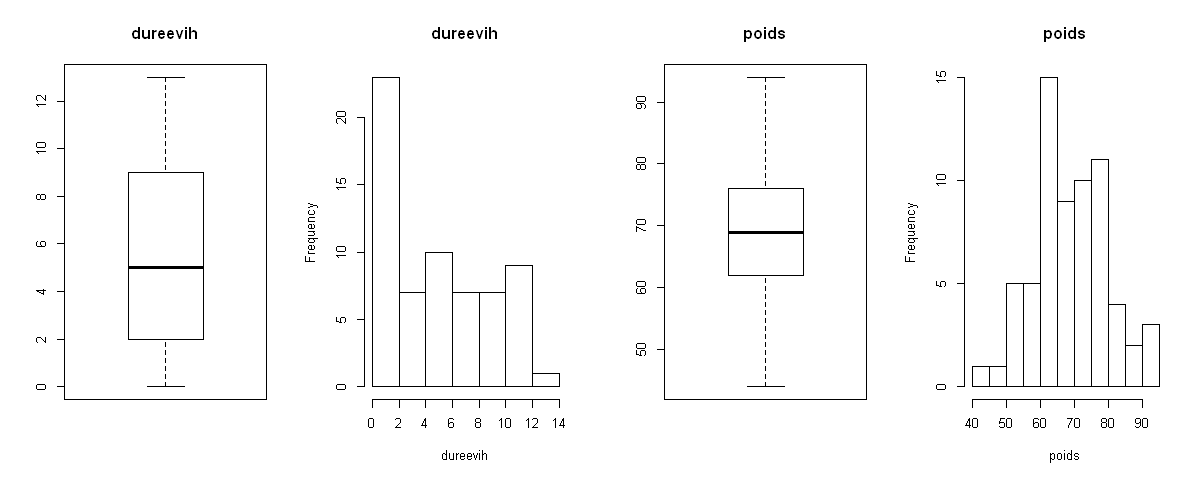

In [7]:
# Distribution des variables numériques 
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1, 4))

for(var in num_vars){
    boxplot(data[, var], main=toString(var))
    hist(data[, var], main=toString(var), xlab=var)
}

<br>Concernant les variables explicatives numériques, on peut noter que `age`, `agesero`, `dureevih` et `poids` ont une médiane proche de leur moyenne.
<br>Les variables `age` et `agesero` sont assez dispersées : la première s'étend de 26 à 72 ans, la seconde de 15 à 71. Même constat pour `poids`, de 44 à 94 kg. Quant à la durée depuis la détection de la séropositivité (`dureevih`), elle s'étend de 0 à 13 ans.

## Observation des `cd4` par instant et par groupe

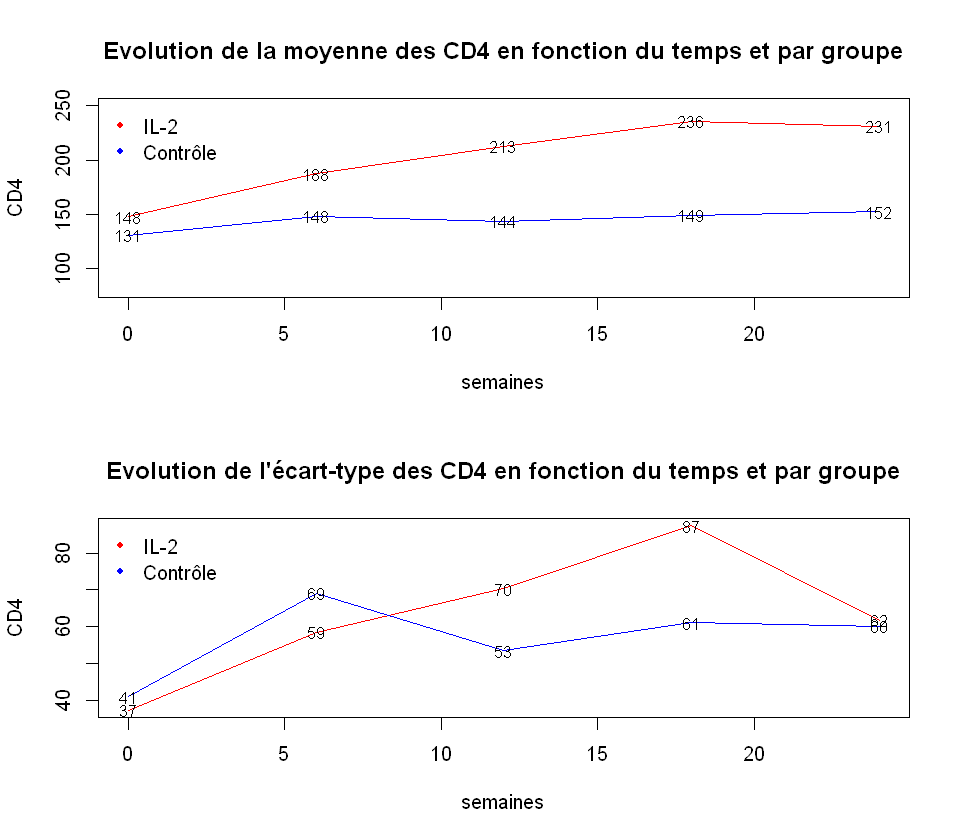

In [8]:
# Code non affiché

En moyenne, à chaque instant le groupe sous traitement IL-2 a un nombre de lymphocytes CD4 plus élevé que le groupe contrôle. Cet écart tend à s'accroître au cours du temps. Le groupe IL-2 gagne en moyenne 83 lymphocytes CD4 entre l'instant 0 et l'instant 24, tandis que le groupe contrôle n'en gagne que 21.
L'écart-type augmente globalement entre les instants 0 et 24 pour les 2 groupes, sans qu'on puisse noter une grande différence entre les 2 groupes. 

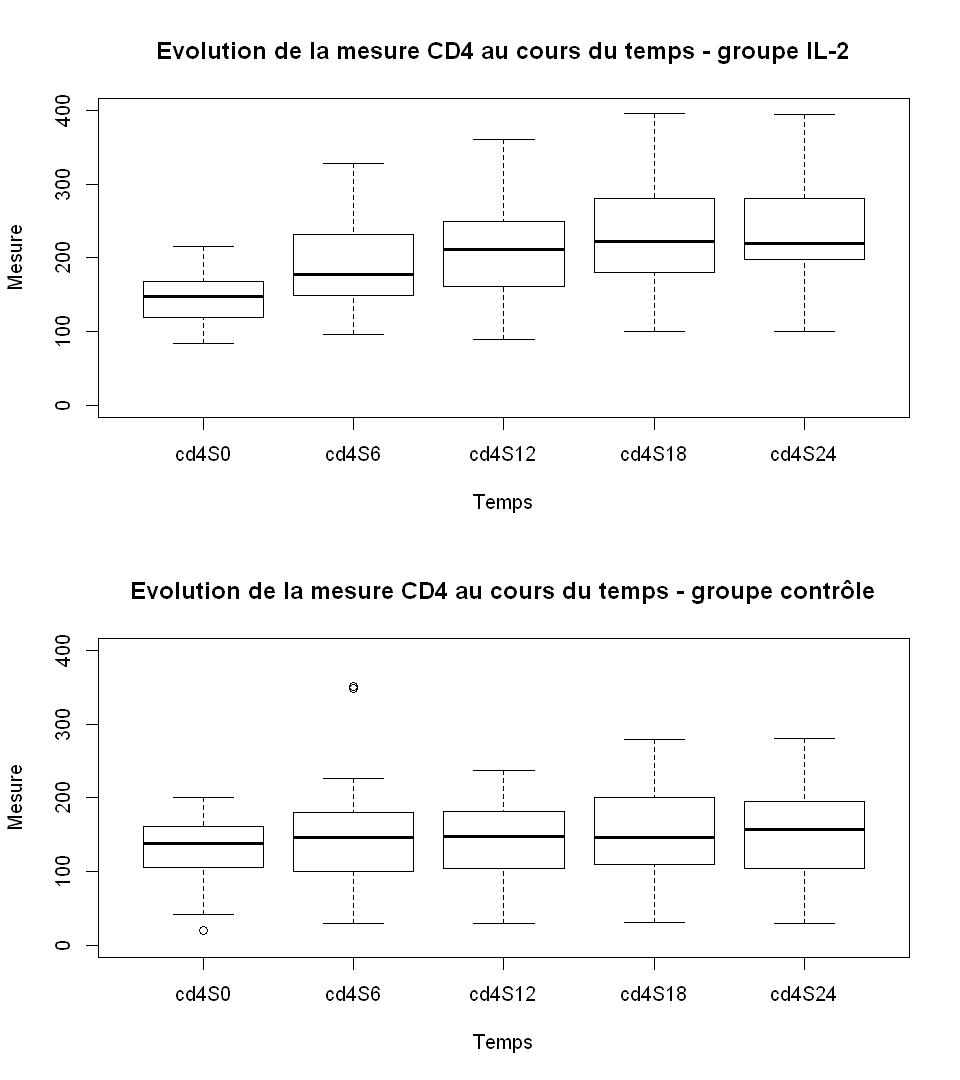

In [9]:
# Code non affiché

On complète l'analyse descriptive en observant la distribution de la variable réponse à chaque instant pour chacun des 2 groupes. On remarque que la dispersion augmente au cours du temps pour les 2 groupes, mais avec une augmentation plus nette chez le groupe IL-2, et une dispersion plus grande que le groupe contrôle en fin de traitement.
Cela suggère que le traitement a des effets de plus en plus différents sur les personnes au cours du temps.

In [10]:
# Test de normalité sur les variables réponses
for(t in target){
    cat(t)
    print(shapiro.test(get(t)))
}

cd4S0
	Shapiro-Wilk normality test

data:  get(t)
W = 0.98188, p-value = 0.4472

cd4S6
	Shapiro-Wilk normality test

data:  get(t)
W = 0.96507, p-value = 0.05992

cd4S12
	Shapiro-Wilk normality test

data:  get(t)
W = 0.98097, p-value = 0.4055

cd4S18
	Shapiro-Wilk normality test

data:  get(t)
W = 0.95212, p-value = 0.01257

cd4S24
	Shapiro-Wilk normality test

data:  get(t)
W = 0.98522, p-value = 0.6212



Les tests de Shapiro-Wilk renvoient des p-values non significatives (supérieures à 0,05) pour toutes les variables `cd4`, sauf `cd4S18`. Les distributions de 4 variables réponses sur 5 sont donc supposées gaussiennes. Il faudra bien veiller à vérifier a posteriori la normalité des résidus.

<br>

**Modélisation :**
<br>

<br>Dans un premier temps, on observera l'évolution des `cd4` en fonction du temps et selon le groupe de traitement, d'abord avec des ANOVAs à un facteur, puis en mettant en oeure un modèle à un facteur pour données répétées pour prendre en compte la dépendance entre les différentes observations au cours du temps.
<br>
Dans un second temps, on cherchera à voir si la prise en compte d'autres covariables ou facteurs permet d'améliorer le modèle.

# Evolution des CD4 en fonction du temps et selon le groupe

## Analyse unidimensionnelle

In [11]:
# ANOVAs par instants 
mod.cd4 <- lm(cd4 ~ groupe)
H <- summary(aov(mod.cd4))  # tests d'absence d'effet du facteur par instant
LM <- summary(mod.cd4)  # estimations des paramètres de l'ANOVA à un facteur par instant

# R2, coefficient de variation et p-value de l'effet groupe
R2 <- sapply(LM, function(x)x$r.squared)
Coef_var <- sapply(H, function(x)sqrt(x$Mean[nrow(x)])) / apply(cd4, 2, mean)
p.val.groupe <- sapply(H, function(x)x$Pr[1])
print(rbind(R2, Coef_var, p.val.groupe), digits=2)

             Response cd4S0 Response cd4S6 Response cd4S12 Response cd4S18
R2                    0.046          0.087         2.4e-01         2.6e-01
Coef_var              0.284          0.389         3.5e-01         3.9e-01
p.val.groupe          0.084          0.016         2.7e-05         1.3e-05
             Response cd4S24
R2                   3.0e-01
Coef_var             3.2e-01
p.val.groupe         2.0e-06


L'analyse unidimensionnelle sur les 5 variables réponses, qui correspond à une ANOVA à un facteur pour chaque instant, est résumée dans le tableau ci-dessus.
<br>On remarque que l'effet du facteur `groupe` n'est pas significatif à l'instant 0 (p-valeur supérieure à 5%), ce qui est normal puisqu'à ce stade le traitement n'a pas encore commencé. L'effet devient significatif dès l'instant 6, qui correspond à la première des visites effectuées après le début du traitement.

## Analyse multidimensionnelle
On met en oeure un modèle à un facteur pour données répétées pour prendre en compte la dépendance entre les différentes observations au cours du temps.
<br>
On cherche à savoir si le nombre de `cd4` varie selon le groupe (traitement IL-2 ou contrôle) et/ou au cours du temps.
<br>
On commencera par observer les effets inter-sujets (effet du facteur `groupe`), qui ne dépendent pas du temps. On vérifiera ensuite la validité de l'hypothèse de sphéricité pour choisir la structure de covariance appropriée, avant d'analyser les effets intra-sujets, c'est-à-dire l'interaction entre le groupe et le temps.

In [12]:
# On utilise le modèle précédemment estimé en ajoutant le temps.
fact.temps <- data.frame(TEMPS=as.factor(1:5))
mod.cd4.tps <- Anova(mod.cd4, idata=fact.temps, idesign=~TEMPS, type='III', test='Wilks')

**Effets inter-sujets**

In [13]:
res_aov <- summary(mod.cd4.tps)
res_aov$univariate.tests

              Sum Sq num Df Error SS den Df  F value    Pr(>F)    
(Intercept)  6176073      1   839359     64 470.9174 < 2.2e-16 ***
groupe        276472      1   839359     64  21.0806 2.114e-05 ***
TEMPS         157622      4   359109    256  28.0912 < 2.2e-16 ***
groupe:TEMPS   55457      4   359109    256   9.8834 1.885e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Les effets inter-sujets ne dépendent pas du temps. On teste ci-dessus l'effet du facteur `groupe` avec le test de Fisher : on détecte un effet très significatif du groupe, avec une p-valeur de 2.114e-05.

**Test de sphéricité**

In [14]:
res_aov <- summary(mod.cd4.tps)
res_aov$sphericity.tests

             Test statistic  p-value
TEMPS               0.73062 0.020657
groupe:TEMPS        0.73062 0.020657

Le test de Mauchly donne une p-value égale à 0.020657 < 5%. On rejette donc l'hypothèse de sphéricité, et donc la possibilité d'utiliser une structure de covariance de symmétrie composée. On devra donc utiliser une autre structure de covariance.

**Effets intra-sujets**

In [15]:
res_aov$pval.adjustments

,GG eps,Pr(>F[GG]),HF eps,Pr(>F[HF])
TEMPS,0.8525855,7.522852e-17,0.9063933,9.169986e-18
groupe:TEMPS,0.8525855,1.190510e-06,0.9063933,6.069267e-07


Pour juger des effets intra-sujets, on observe les résultats des tests de Fisher corrigés Greenhouse-Geisser et Huynh-Feldt. L'interaction entre le groupe et le temps est confirmée, et l'effet du temps est très significatif.


Nous allons maintenant chercher une structure de covariance adaptée au modèle, avec les librairies `nlme` et `gls`. Au préalable, nous devons mettre le tableau de données au format adéquat.

In [16]:
# Transformation du tableau de données
numpat <- factor(rep(rownames(data), 5))
groupe_ <- factor(rep(groupe, 5))
temps <- rep(0, dim(data)[1])
for(i in c(6, 12, 18, 24)){temps <- c(temps, rep(i, dim(data)[1]))}
temps <- factor(temps)
cd4_ <- as.numeric(unlist(data[, 2:6]))
data2 <- data.frame(numpat, temps, groupe_, cd4_)

In [17]:
# On estime le modèle avec les différentes structures de covariance
# Structure de covariance non structurée
Mod.Un <- gls(cd4_ ~ groupe_ * temps, method='REML', correlation=corSymm(form=~1|numpat), weights=varIdent(form=~1|temps))
# Structure de covariance AR1
Mod.AR <- gls(cd4_ ~ groupe_ * temps, method='REML', correlation=corAR1(form=~1|numpat))
# Structure de covariance Toeplitz à 2 bandes
Mod.TOEP2 <- gls(cd4_ ~ groupe_ * temps, method='REML', correlation=corARMA(form=~1|numpat, p=0, q=1))
# Structure de covariance Toeplitz générale
Mod.TOEPg <- gls(cd4_ ~ groupe_ * temps, method='REML', correlation=corARMA(form=~1|numpat, p=3, q=1))

In [18]:
# AIC et BIC selon les structures de covariance
rbind(AIC(Mod.Un), AIC(Mod.AR), AIC(Mod.TOEP2), AIC(Mod.TOEPg))

3399.247
3468.804
3515.652
3434.180


In [19]:
rbind(BIC(Mod.Un), BIC(Mod.AR), BIC(Mod.TOEP2), BIC(Mod.TOEPg))

3493.455
3514.024
3560.872
3490.705


On choisit une structure minimisant AIC et BIC. La structure `Un` (absence de structure) minimise AIC, tandis que la structure `TOEPg` (structure de Toeplitz générale) minimise BIC. La structure `Un` comporte davantage de paramètres à estimer, mais étant donné que son AIC est de loin le plus faible, et son BIC très proche de celui de `TOPEg`, on retient cette structure.

In [20]:
final_model <- summary(Mod.Un)
final_model$coefficients

                     Value Std.Error   t-value p-value
(Intercept)      147.63333  7.179956 20.561870  0.0000
groupe_2         -17.05000  9.721707 -1.753807  0.0804
temps6            39.93333  9.397987  4.249137  0.0000
temps12           64.96667  8.184135  7.938122  0.0000
temps18           88.20000 10.633704  8.294382  0.0000
temps24           83.30000  8.502720  9.796865  0.0000
groupe_2:temps6  -22.32222 12.724935 -1.754211  0.0804
groupe_2:temps12 -51.96667 11.081372 -4.689552  0.0000
groupe_2:temps18 -69.61667 14.398103 -4.835128  0.0000
groupe_2:temps24 -61.49444 11.512737 -5.341427  0.0000



Les patients du groupe sous traitement IL-2 ont plus de lymphocytes CD4 que ceux du groupe contrôle, et cette différence s'accroît significativement au cours du temps de la semaine 12 à la semaine 18 : 51.97 et 69.62 CD4 de plus respectivement pour les semaines 12 et 18. A la semaine 24, la différence est plus basse : 61.49.

# Prise en compte du facteur `stratcd4`
La variable `stratcd4` donne le groupe de CD4 à l'inclusion : 1 si CD4 < 100, 2 sinon. On cherche à voir si ce facteur a des effets significatifs dans le modèle. On commence par une ANOVA pour chaque instant, avec les facteurs `groupe` et `stratcd4`.

In [21]:
mod.cd4 <- lm(cd4 ~ groupe * stratcd4)
H <- summary(aov(mod.cd4))
LM <- summary(mod.cd4)
R2 <- sapply(LM, function(x)x$r.squared)
             
Coef_var <- sapply(H, function(x)sqrt(x$Mean[nrow(x)])) / apply(cd4, 2, mean)
p.val.groupe <- sapply(H, function(x)x$Pr[1])
p.val.stratcd4 <- sapply(H, function(x)x$Pr[2])
p.val.interaction <- sapply(H, function(x)x$Pr[3])
print(rbind(R2, Coef_var, p.val.groupe, p.val.stratcd4, p.val.interaction), digits=2)

                  Response cd4S0 Response cd4S6 Response cd4S12 Response cd4S18
R2                       4.6e-01        3.5e-01         5.0e-01         4.2e-01
Coef_var                 2.2e-01        3.3e-01         2.9e-01         3.5e-01
p.val.groupe             2.5e-02        5.4e-03         8.2e-07         1.9e-06
p.val.stratcd4           3.3e-09        4.4e-06         4.9e-07         1.0e-04
p.val.interaction        6.6e-01        6.5e-01         5.1e-01         6.6e-01
                  Response cd4S24
R2                        5.3e-01
Coef_var                  2.7e-01
p.val.groupe              3.7e-08
p.val.stratcd4            6.9e-07
p.val.interaction         7.9e-01


On remarque que l'effet du facteur `stratcd4` est très significatif à l'instant 0 (p-valeur inférieure à 5%), ce qui est normal puisque la mesure de `stratcd4` est faite à cet instant. L'effet reste significatif à tous les instants suivants.
<br>L'effet de l'interaction entre `groupe` et `stratcd4` n'est pas significatif.

In [22]:
fact.temps <- data.frame(TEMPS=as.factor(1:5))
mod.cd4.tps <- Anova(mod.cd4, idata=fact.temps, idesign=~TEMPS, type='III', test='Wilks')
res_aov <- summary(mod.cd4.tps)
res_aov$univariate.tests

                      Sum Sq num Df Error SS den Df F value    Pr(>F)    
(Intercept)           223016      1   487100     62 28.3863 1.468e-06 ***
groupe                 22967      1   487100     62  2.9233 0.0923106 .  
stratcd4              109296      1   487100     62 13.9116 0.0004176 ***
groupe:stratcd4           24      1   487100     62  0.0031 0.9558337    
TEMPS                   7068      4   351817    248  1.2455 0.2922086    
groupe:TEMPS            4246      4   351817    248  0.7483 0.5599600    
stratcd4:TEMPS          4571      4   351817    248  0.8056 0.5225908    
groupe:stratcd4:TEMPS   2986      4   351817    248  0.5262 0.7165791    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Le test de Fisher nous confirme que l'effet du facteur `stratcd4` seul est significatif. L'interaction avec le temps n'est pas significative. On pourra donc ajouter le facteur `stratcd4` au modèle. Pour l'instant, notre modèle peut s'écrire : **`groupe * temps + strat`**. On peut réprésenter les effets temps, groupe et strat sur un même graphe :

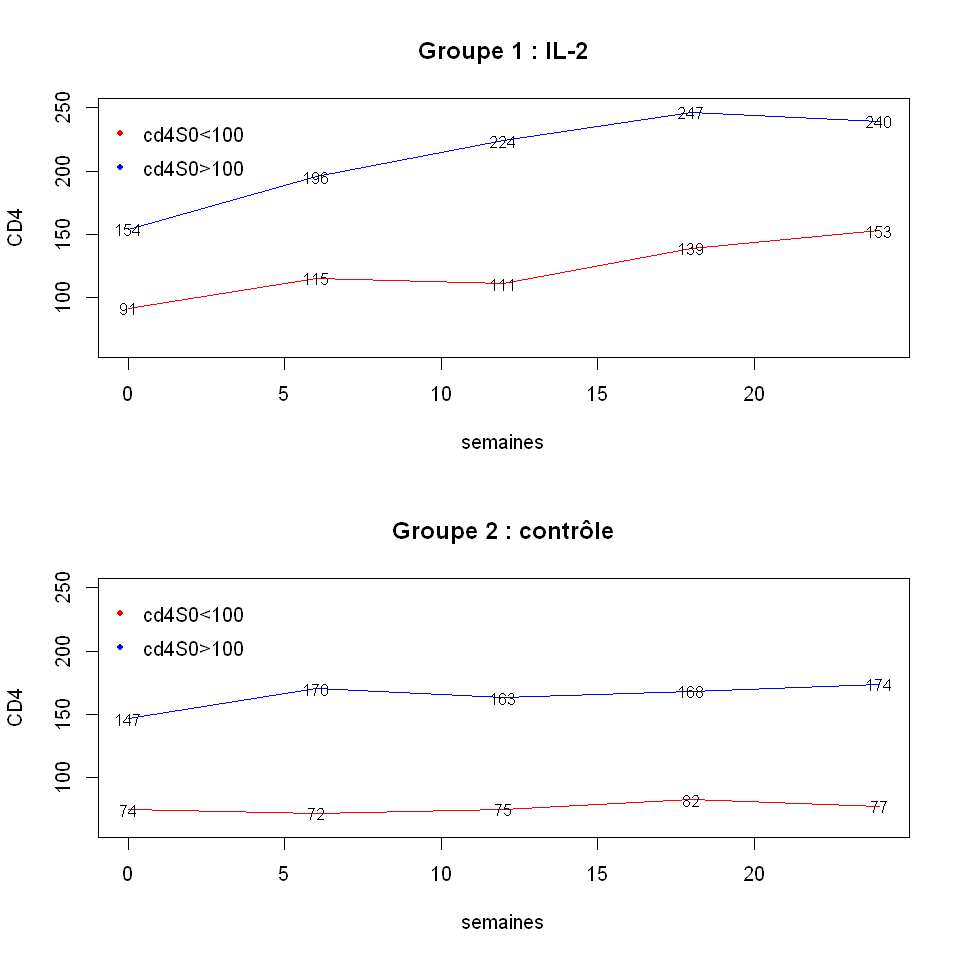

In [23]:
# Code non affiché :
# Moyennes des CD4 par visite et par stratcd4 pour le groupe 1 (IL-2)
# Moyennes des CD4 par visite et par stratcd4 pour le groupe 2 (contrôle)

Dans le groupe IL-2, le traitement permet une augmentation du nombre de lymphocytes CD4 de 55% (+86) entre le début et la fin du traitement pour les patients qui étaient au-dessus de 100 dès l'inclusion (`stratcd4`=2). Cette augmentation est de 68% (+62) pour les patients qui étaient en-dessous de 100 à l'inclusion (`stratcd4`=1).
<br>
Dans le groupe contrôle, l'augmentation est de 18% (+27) lymphocytes CD4 en moyenne pour les patients de `stratcd4`=2. Elle est de 4% (+3) pour les patients de `stratcd4`=1. Cela nous permet de confirmer que le groupe sous traitement et le groupe contrôle connaissent des évolutions significativement différentes de leur nombre de CD4 au cours du temps.
<br>L'effet du facteur `stratcd4` vient s'ajouter : on remarque que le nombre de CD4 des patients qui ne suivent pas le traitement tend à augmenter davantage (en %) quand la valeur de départ est supérieure à 100, mais chez les patients qui suivent le traitement, ceux qui commencent avec une valeur inférieure à 100 connaissent une plus forte évolution.

# Prise en compte de la variable `agesero`
La variable `agesero` donne l'âge auquel la séropositivité du patient a été détectée. On cherche à voir si elle a des effets significatifs dans le modèle. On commence par retirer les valeurs manquantes de `agesero` (code non affiché).

On transforme ensuite `agesero` en facteur : on la recode en 5 facteurs à parts égales.

In [24]:
# Recode selon 5 quantiles
agesero[agesero < 30] <- '29_ans_moins'
agesero[agesero >= 30 & agesero < 38] <- '30_37'
agesero[agesero >= 38 & agesero < 43] <- '38_42'
agesero[agesero >= 43 & agesero < 49] <- '43_48'
agesero[agesero >= 49] <- '49_ans_plus'

On réalise une ANOVA pour chaque instant, avec le facteurs `groupe`.

In [25]:
# Code non affiché

                      Sum Sq num Df Error SS den Df  F value    Pr(>F)    
(Intercept)          1353965      1   567578     54 128.8176 6.408e-16 ***
groupe                 40039      1   567578     54   3.8094   0.05616 .  
agesero               128086      4   567578     54   3.0465   0.02455 *  
groupe:agesero         78481      4   567578     54   1.8667   0.12965    
TEMPS                  44418      4   296965    216   8.0769 4.362e-06 ***
groupe:TEMPS           12381      4   296965    216   2.2514   0.06461 .  
agesero:TEMPS          42523     16   296965    216   1.9331   0.01893 *  
groupe:agesero:TEMPS   24942     16   296965    216   1.1339   0.32524    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

On remarque ici que le facteur `agesero` a un effet significatif (p-valeur = 0.02455 < 5%). L'interaction avec le temps est également significative (p-valeur = 0.01893 < 5%). En revanche, l'interaction d'ordre maximal n'est pas significative. On pourra ajouter `agesero` à notre modèle final, sans interaction.

# Modèle final
De la même manière, on teste la prise en compte des autres covariables et facteurs. On peut retenir que `poids`, `sexe`, `dureevih`, `trans`, `age` et `vihact` n'apportent pas d'effets significatifs au modèle. Ce constat est toutefois moins net pour deux dernières variables citées ; notamment, l'interaction entre `vihact` et le temps dans un modèle contenant `groupe`, `vihact` et temps donne une p-value proche de 7%.
<br>Finalement, on retient le modèle : **`groupe * temps + strat + agesero`**. On commencera par commenter les effets inter-sujets. On vérifiera ensuite la validité de l'hypothèse de sphéricité pour choisir la structure de covariance appropriée, avant d'analyser les effets intra-sujets.

In [26]:
# Code non affiché : on estime le modèle avec les différentes structures de covariance

In [27]:
# AIC et BIC selon les structures de covariance
rbind(AIC(Mod.Un), AIC(Mod.AR), AIC(Mod.TOEP2), AIC(Mod.TOEPg))

3227.374
3278.993
3294.185
3259.775


In [28]:
rbind(BIC(Mod.Un), BIC(Mod.AR), BIC(Mod.TOEP2), BIC(Mod.TOEPg))

3338.983
3342.239
3357.431
3334.182


On choisit la structure minimisant AIC et BIC : la structure `Un` (absence de structure). On observe ensuite les estimations des paramètres du modèle, afin d'évaluer les effets des modalités des facteurs et les interactions de `groupe` et temps.

In [29]:
final_model <- summary(Mod.Un)
print(final_model$coefficients)
shapiro.test(Mod.Un$residuals)

                        Value Std.Error   t-value p-value
(Intercept)          93.42258 14.082807  6.633804  0.0000
groupe_2             -5.11547  7.607461 -0.672427  0.5018
temps6               39.93333  9.454396  4.223785  0.0000
temps12              64.96667  8.106276  8.014366  0.0000
temps18              88.20000 10.692698  8.248619  0.0000
temps24              83.30000  8.589648  9.697720  0.0000
strat_2              68.50429  9.809432  6.983512  0.0000
agesero_30_37        -5.69290 11.803669 -0.482299  0.6299
agesero_38_42         2.26276 11.296798  0.200301  0.8414
agesero_43_48       -10.65441 11.741384 -0.907424  0.3649
agesero_49_ans_plus -31.92385 11.658854 -2.738164  0.0065
groupe_2:temps6     -24.63922 12.971324 -1.899514  0.0584
groupe_2:temps12    -55.02549 11.121719 -4.947570  0.0000
groupe_2:temps18    -72.14118 14.670261 -4.917511  0.0000
groupe_2:temps24    -61.56471 11.784900 -5.224033  0.0000

	Shapiro-Wilk normality test

data:  Mod.Un$residuals
W = 0.94461, p-va

Les patients du groupe sous traitement IL-2 ont plus de lymphocytes CD4 que ceux du groupe contrôle, et cette différence s'accroît au cours du temps de la semaine 6 à la semaine 18 : 24.64, 55.03 et 71.14 CD4 de plus respectivement pour les semaines 6, 12 et 18. A la semaine 24, la différence est plus basse : 61.56.
<br>
Concernant l'âge de détection de la séropositivité, les patients dont l'`agesero` est supérieur à 49 ans présentent une différence significative avec les autres groupes d'`agesero` : ils ont moins de CD4 (en moyenne 31.92 de moins que le groupe `agesero` moins de 30 ans).
<br>
Enfin, en observant la strate de CD4 à l'inclusion, on remarque que les patients du groupe `stratcd4`=2 (>100) ont en moyenne 68.5 lymphocytes CD4 de plus que ceux du groupe 1 (<100). Si on a vu précédemment que le traitement provoquait une augmentation plus forte (en %) chez les patients du groupe `stratcd4`=1, leur nombre de CD4 reste tout de même largement inférieur au nombre de CD4 du groupe `stratcd4`=2.
<br>Toutefois, le test de Shapiro-Wilk renvoie une p-valeur significative (<5%), la distribution des résidus n'est donc pas gaussienne et ne permet pas de valider le modèle.